---
title: Gradient Descent Continuation, Feature Engineering (Fall 2025)
---

::: {note}  Learning Outcomes
* Recognize the value of feature engineering as a tool to improve model performance
* Implement polynomial feature generation and one hot encoding
* Understand the interactions between model complexity, model variance, and training error
:::

At this point, we've grown quite familiar with the modeling process. We've introduced the concept of loss, used it to fit several types of models, and, most recently, extended our analysis to multiple regression. Along the way, we've forged our way through the mathematics of deriving the optimal model parameters in all its gory detail. It's time to make our lives a little easier – let's implement the modeling process in code!

In this lecture, we'll explore two techniques for model fitting:

1. Translating our derived formulas for regression to `python`
2. Using `python`'s `sklearn` package

With our new programming frameworks in hand, we will also add sophistication to our models by introducing more complex features to enhance model performance. 

## Gradient Descent Part 2

Before we dive into feature engineering, let's expand on gradient descent, which we began covering in the last lecture. Recall that gradient descent is a powerful technique for choosing the model parameters that minimize the loss function.  

### Gradient Descent on Multi-Dimensional Models
The function we worked with above was one-dimensional – we were only minimizing the function with respect to a single parameter, $\theta$. However, models usually have a cost function with multiple parameters that need to be optimized. For example, simple linear regression has 2 parameters: 
$$\hat{y} + \theta_0 + \theta_1x$$ 
and multiple linear regression has $p+1$ parameters: 
$$\mathbb{Y} = \theta_0 + \theta_1 \Bbb{X}_{:,1} + \theta_2 \Bbb{X}_{:,2} + \cdots + \theta_p \Bbb{X}_{:,p}$$

We'll need to expand gradient descent so we can update our guesses for all model parameters all in one go.

With multiple parameters to optimize, we consider a **loss surface**, or the model's loss for a particular *combination* of possible parameter values.

````{dropdown} Click to see the code
```python
import seaborn as sns
import numpy as np
df = sns.load_dataset("tips")
```
````

In [1]:
import seaborn as sns
import numpy as np
df = sns.load_dataset("tips")

````{dropdown} Click to see the code
```python
import plotly.graph_objects as go


def mse_loss(theta, X, y_obs):
    y_hat = X @ theta
    return np.mean((y_hat - y_obs) ** 2)    

tips_with_bias = df.copy()
tips_with_bias["bias"] = 1
tips_with_bias = tips_with_bias[["bias", "total_bill"]]

uvalues = np.linspace(0, 2, 10)
vvalues = np.linspace(-0.1, 0.35, 10)
(u,v) = np.meshgrid(uvalues, vvalues)
thetas = np.vstack((u.flatten(),v.flatten()))

def mse_loss_single_arg(theta):
    return mse_loss(theta, tips_with_bias, df["tip"])

MSE = np.array([mse_loss_single_arg(t) for t in thetas.T])

loss_surface = go.Surface(x=u, y=v, z=np.reshape(MSE, u.shape))

ind = np.argmin(MSE)
optimal_point = go.Scatter3d(name = "Optimal Point",
    x = [thetas.T[ind,0]], y = [thetas.T[ind,1]], 
    z = [MSE[ind]],
    marker=dict(size=10, color="red"))

fig = go.Figure(data=[loss_surface, optimal_point])
fig.update_layout(scene = dict(
    xaxis_title = "theta0",
    yaxis_title = "theta1",
    zaxis_title = "MSE"), autosize=False, width=800, height=600)

fig.show()
```
````

In [2]:
import plotly.graph_objects as go


def mse_loss(theta, X, y_obs):
    y_hat = X @ theta
    return np.mean((y_hat - y_obs) ** 2)    

tips_with_bias = df.copy()
tips_with_bias["bias"] = 1
tips_with_bias = tips_with_bias[["bias", "total_bill"]]

uvalues = np.linspace(0, 2, 10)
vvalues = np.linspace(-0.1, 0.35, 10)
(u,v) = np.meshgrid(uvalues, vvalues)
thetas = np.vstack((u.flatten(),v.flatten()))

def mse_loss_single_arg(theta):
    return mse_loss(theta, tips_with_bias, df["tip"])

MSE = np.array([mse_loss_single_arg(t) for t in thetas.T])

loss_surface = go.Surface(x=u, y=v, z=np.reshape(MSE, u.shape))

ind = np.argmin(MSE)
optimal_point = go.Scatter3d(name = "Optimal Point",
    x = [thetas.T[ind,0]], y = [thetas.T[ind,1]], 
    z = [MSE[ind]],
    marker=dict(size=10, color="red"))

fig = go.Figure(data=[loss_surface, optimal_point])
fig.update_layout(scene = dict(
    xaxis_title = "theta0",
    yaxis_title = "theta1",
    zaxis_title = "MSE"), autosize=False, width=800, height=600)

fig.show()

We can also visualize a bird's-eye view of the loss surface from above using a contour plot:

````{dropdown} Click to see the code
```python
contour = go.Contour(x=u[0], y=v[:, 0], z=np.reshape(MSE, u.shape))
fig = go.Figure(contour)
fig.update_layout(
    xaxis_title = "theta0",
    yaxis_title = "theta1", autosize=False, width=800, height=600)

fig.show()
```
````

In [3]:
contour = go.Contour(x=u[0], y=v[:, 0], z=np.reshape(MSE, u.shape))
fig = go.Figure(contour)
fig.update_layout(
    xaxis_title = "theta0",
    yaxis_title = "theta1", autosize=False, width=800, height=600)

fig.show()

#### The Gradient Vector
As before, the derivative of the loss function tells us the best way towards the minimum value.

On a 2D (or higher) surface, the best way to go down (gradient) is described by a *vector*.

```{image} images/loss_surface.png
:alt: 3D loss surface
:width: 600
```

::: {tip} Math Aside: Partial Derivatives 

- For an equation with multiple variables, we take a **partial derivative** by differentiating with respect to just one variable at a time. The partial derivative is denoted with a $\partial$. Intuitively, we want to see how the function changes if we only vary one variable while holding other variables constant. 
- Using $f(x, y) = 3x^2 + y$ as an example,
   - taking the partial derivative with respect to x and treating y as a constant gives us $\frac{\partial f}{\partial x} = 6x$
   - taking the partial derivative with respect to y and treating x as a constant gives us $\frac{\partial f}{\partial y} = 1$
:::

For the *vector* of parameter values $\vec{\theta} = \begin{bmatrix}
           \theta_{0} \\
           \theta_{1} \\
         \end{bmatrix}$, we take the *partial derivative* of loss with respect to each parameter: $\frac{\partial L}{\partial \theta_0}$ and $\frac{\partial L}{\partial \theta_1}$.

> For example, consider the 2D function: $$f(\theta_0, \theta_1) = 8 \theta_0^2 + 3\theta_0\theta_1$$
> For a function of 2 variables $f(\theta_0, \theta_1)$, we define the gradient 

\begin{align}
\frac{\partial f}{\partial \theta_{0}} &= 16\theta_0 + 3\theta_1 \\
\frac{\partial f}{\partial \theta_{1}} &= 3\theta_0 \\
\nabla_{\vec{\theta}} f(\vec{\theta}) &=  \begin{bmatrix} 16\theta_0 + 3\theta_1 \\ 3\theta_0 \\ \end{bmatrix}
\end{align}


The **gradient vector** of a generic function of $p+1$ variables is therefore 
$$\nabla_{\vec{\theta}} L =  \begin{bmatrix} \frac{\partial L}{\partial \theta_0} \\ \frac{\partial L}{\partial \theta_1} \\ \vdots \\ \frac{\partial L}{\partial \theta_p} \end{bmatrix}$$
where $- \nabla_{\vec{\theta}} L$ always points in the downhill direction of the surface. We can interpret each gradient as: "If I nudge the $i$th model weight, what happens to loss?"

We can use this to update our 1D gradient rule for models with multiple parameters. 

* Recall our 1D update rule: $$\theta^{(t+1)} = \theta^{(t)} - \alpha \frac{d}{d\theta}L(\theta^{(t)})$$ 
* For models with multiple parameters, we work in terms of vectors:
$$\begin{bmatrix}
           \theta_{0}^{(t+1)} \\
           \theta_{1}^{(t+1)} \\
           \vdots
         \end{bmatrix} = \begin{bmatrix}
           \theta_{0}^{(t)} \\
           \theta_{1}^{(t)} \\
           \vdots
         \end{bmatrix} - \alpha \begin{bmatrix}
           \frac{\partial L}{\partial \theta_{0}} \\
           \frac{\partial L}{\partial \theta_{1}} \\
           \vdots \\
         \end{bmatrix}
         $$
  
* Written in a more compact form, $$\vec{\theta}^{(t+1)} = \vec{\theta}^{(t)} - \alpha \nabla_{\vec{\theta}} L(\theta^{(t)}) $$

  * $\theta$ is a vector with our model weights
  * $L$ is the loss function
  * $\alpha$ is the learning rate (ours is constant, but other techniques use an $\alpha$ that decreases over time)
  * $\vec{\theta}^{(t)}$ is the current value of $\theta$
  * $\vec{\theta}^{(t+1)}$ is the next value of $\theta$
  * $\nabla_{\vec{\theta}} L(\vec{\theta}^{(t)})$ is the gradient of the loss function evaluated at the current $\theta$: $$\frac{1}{n}\sum_{i=1}^{n}\nabla_{\vec{\theta}} l(y_i, f_{\vec{\theta}^{(t)}}(X_i))$$

Note that $-\nabla_{\vec{\theta}} L$ always points in the **downhill direction** of the surface. 

Let's now walk through an example of calculating and updating the gradient vector. Say our model and loss are:
$$\begin{align}
f_{\vec{\theta}}(\vec{x}) &= \vec{x}^T\vec{\theta} = \theta_0x_0 + \theta_1x_1
\\l(y, \hat{y}) &= (y - \hat{y})^2
\end{align}
$$

Plugging in $f_{\vec{\theta}}(\vec{x})$ for $\hat{y}$, our loss function becomes $l(\vec{\theta}, \vec{x}, y_i) = (y_i - \theta_0x_0 - \theta_1x_1)^2$.

To calculate our gradient vector, we can start by computing the partial derivative of the loss function with respect to $\theta_0$: $$\frac{\partial}{\partial \theta_{0}} l(\vec{\theta}, \vec{x}, y_i) = 2(y_i - \theta_0x_0 - \theta_1x_1)(-x_0)$$

Let's now do the same but with respect to $\theta_1$: $$\frac{\partial}{\partial \theta_{1}} l(\vec{\theta}, \vec{x}, y_i) = 2(y_i - \theta_0x_0 - \theta_1x_1)(-x_1)$$

Putting this together, our gradient vector is: 
$$\nabla_{\theta} l(\vec{\theta}, \vec{x}, y_i) =  \begin{bmatrix} -2(y_i - \theta_0x_0 - \theta_1x_1)(x_0) \\ -2(y_i - \theta_0x_0 - \theta_1x_1)(x_1) \end{bmatrix}$$

Remember that we need to keep updating $\theta$ until the algorithm **converges** to a solution and stops updating significantly (or at all). When updating $\theta$, we'll have a fixed number of updates and subsequent updates will be quite small (we won't change $\theta$ by much).

### Stochastic (Mini-batch) Gradient Descent

Formally, the algorithm we derived above is called **batch gradient descent.** For each iteration of the algorithm, the derivative of loss is computed across the *entire* batch of all $n$ datapoints. While this update rule works well in theory, it is not practical in most circumstances. For large datasets (with perhaps billions of datapoints), finding the gradient across all the data is incredibly computationally taxing; gradient descent will converge slowly because each individual update is slow.

**Stochastic (mini-batch) gradient descent** tries to address this issue. In stochastic descent, only a *sample* of the full dataset is used at each update. We estimate the true gradient of the loss surface using just that sample of data. The **batch size** is the number of data points used in each sample. The sampling strategy is generally without replacement (data is shuffled and batch size examples are selected one at a time.)

Each complete "pass" through the data is known as a **training epoch**. After shuffling the data, in a single **training epoch** of stochastic gradient descent, we

* Compute the gradient on the first x% of the data. Update the parameter guesses.
* Compute the gradient on the next x% of the data. Update the parameter guesses.
* $\dots$
* Compute the gradient on the last x% of the data. Update the parameter guesses.

Every data point appears once in a single training epoch. We then perform several training epochs until we're satisfied.

Batch gradient descent is a deterministic technique – because the entire dataset is used at each update iteration, the algorithm will always advance towards the minimum of the loss surface. In contrast, stochastic gradient descent involve an element of randomness. Since only a subset of the full data is used to update the guess for $\vec{\theta}$ at each iteration, there's a chance the algorithm will not progress towards the true minimum of loss with each update. Over the longer term, these stochastic techniques should still converge towards the optimal solution. 

The diagrams below represent a "bird's eye view" of a loss surface from above. Notice that batch gradient descent takes a direct path towards the optimal $\hat{\theta}$. Stochastic gradient descent, in contrast, "hops around" on its path to the minimum point on the loss surface. This reflects the randomness of the sampling process at each update step.

```{image} images/stochastic.png
:alt: Comparison of batch gradient descent and stochastic gradient descent. Batch gradient descent moves smoothly whereas stochastic gradient descent bounces back and forth.
:width: 600
```

### Batch, Mini-batch, Stochastic Gradient Descent
The time complexity of a single gradient descent step takes only $O(nd)$ time where $n$ is the number of samples (rows) and $d$ is the number of features (columns).

```{image} images/complexity_grad_descent.png
:alt: Complexity of gradient descent is O(nd)
:width: 600
```

Suppose we run $T$ iterations. The final complexity would then be $O(Tnd)$. Typically, $n$ is much larger than $T$ and $d$. How can we reduce the cost of this algorithm using a technique from Data 100? Do we really need to use $n$ data points? We don't! Instead, we can use stochastic gradient descent.

We know that our true gradient of $\nabla_{\vec{\theta}} L (\vec{\theta^{(t)}}) = \frac{1}{n}\sum_{i=1}^{n}\nabla_{\vec{\theta}} l(y_i, f_{\vec{\theta}^{(t)}}(X_i))$ has a time complexity of $O(nd)$. Instead of using all $n$ samples to calculate the true gradient of the loss surface, let's use a **probability sample** of our data to **approximate the gradient**! 

Say we sample $b$ records ($s_1, \cdots, s_b$) from our $n$ datapoints. Our new (stochastic) gradient descent function will be: $$\nabla_{\vec{\theta}} L (\vec{\theta}^{(t)}) \approx \frac{1}{\textcolor{red}{b}}\sum_{i=1}^{\textcolor{red}{b}}\nabla_{\vec{\theta}} l(y_{\textcolor{red}{s_i}}, f_{\vec{\theta}^{(t)}}(X_{\textcolor{red}{s_i}}))$$ and will now have a time complexity of $O(bd)$, which is much faster! For more on computational complexity, see the bonus section at the end.

::: {tip} How do we decide our mini-batch size ($b$), or the number of datapoints in our sample? 

Mini-batch size is typically **small**. 

The original Stochastic Gradient Descent algorithm uses $b=1$ so that *only one sample is used* to approximate the gradient at a time. 
When choosing $b$, there are several factors to consider: 
  - larger $b$: better *gradient estimates*, *parallelism*, and other *systems factors*, but also rapidly diminishing returns with more complexity
  - smaller $b$: faster and has *more frequent updates*
  
It is up to data scientists to balance the tradeoff between batch size and time complexity.

Stochastic gradient descent helps us *estimate* the true gradient of the loss surface using just that sample of data, and this allows us to compute gradients quicker. To sample data, there are two sampling strategies we can use:

1. **Shuffle the data** and select batch size records at a time.
2. Take a **simple random sample** for each gradient computation.
:::


Summarizing our two gradient descent techniques:

- **(Batch) Gradient Descent**: GD computes the **true** descent and always descends towards the true minimum of the loss based on a batch (a full dataset). While accurate, it can often be computationally expensive.

```{image} images/gd.png 
:alt: Example of batch gradient descent being calculated.
:width: 300
```

- **(Mini-batch) Stochastic Gradient Descent**: SGD **approximates** the true gradient descent based off of mini-batch (a subset of a dataset). It may not descend towards the true minimum with each update, but it's often less computationally expensive than batch gradient descent. Note that it is mini-batch, because we create a smaller, randomized sample of the batch to run SGD on it.

```{image} images/sgd.png
:alt: Example of stochastic gradient descent being calculated.
:width: 300
```


To summarize the tradeoffs of batch size: 

|  | Smaller Batch Size | Larger Batch Size | 
| -- | -- | -- | 
| **Pros** | More frequent gradient updates | Leverage hardware acceleration to improve overall system performance and higher quality gradient updates | 
| **Cons** | More variability in the gradient estimates | Less frequent gradient updates |

The typical solution is to set batch size to ensure sufficient hardware utilization.

## Feature Engineering

::: {tip} Motivation

At this point in the course, we've equipped ourselves with some powerful techniques to build and optimize models. We've explored how to develop models of multiple variables, as well as how to transform variables to help **linearize** a dataset and fit these models to maximize their performance.

All of this was done with one major caveat: the regression models we've worked with so far are all **linear in the input variables**. We've assumed that our predictions should be some combination of linear variables. While this works well in some cases, the real world isn't always so straightforward. We'll learn an important method to address this issue – feature engineering – and consider some new problems that can arise when we do so.

:::

Feature engineering is the process of *transforming* raw features into *more informative features* that can be used in modeling or EDA tasks and improve model performance.

Feature engineering allows you to:

* Capture domain knowledge 
* Express non-linear relationships using linear models
* Use non-numeric (qualitative) features in models

### Feature Functions

A **feature function** describes the transformations we apply to raw features in a dataset to create a design matrix of transformed features (typically denoted as $\Phi$). When we apply the feature function to our original dataset $\mathbb{X}$, the result, $\Phi(\mathbb{X})$, is a transformed design matrix ready to be used in modeling. 

For example, we might design a feature function that computes the square of an existing feature and adds it to the design matrix. In this case, our existing matrix $[x]$ is transformed to $[x, x^2]$. Its *dimension* increases from 1 to 2. Often, the dimension of the *featurized* dataset increases as seen here.

```{image} images/phi.png
:alt: In this example, applying a feature function adds a column to the dataset.
:width: 700
```

The new features introduced by the feature function can then be used in modeling. Often, we use the symbol $\phi_i$ to represent transformed features after feature engineering. 

$$
\begin{align}
\hat{y} &= \theta_0 + \theta_1 x + \theta_2 x^2 \\
\hat{y} &= \theta_0 + \theta_1 \phi_1 + \theta_2 \phi_2
\end{align}
$$

In matrix notation, the symbol $\Phi$ is sometimes used to denote the design matrix after feature engineering has been performed. Note that in the usage below, $\Phi$ is now a feature-engineered matrix, rather than a function.

$$\hat{\mathbb{Y}} = \Phi \theta$$

More formally, we describe a feature function as transforming the original $\mathbb{R}^{n \times p}$ dataset $\mathbb{X}$ to a featurized $\mathbb{R}^{n \times p'}$ dataset $\mathbb{\Phi}$, where $p'$ is typically greater than $p$. 

$$\mathbb{X} \in \mathbb{R}^{n \times p} \longrightarrow \Phi \in \mathbb{R}^{n \times p'}$$

### One-Hot Encoding
A particularly powerful use of feature engineering is to allow us to perform regression on non-numeric features. **One-hot encoding** is a feature engineering technique that generates numeric features from categorical data, allowing us to use our usual methods to fit a regression model on the data.

To illustrate how this works, we'll refer back to the `tips` dataset from previous lectures. Consider the `"day"` column of the dataset:

````{dropdown} Click to see the code
```python
import numpy as np
import seaborn as sns
import pandas as pd
import sklearn.linear_model as lm
tips = sns.load_dataset("tips")
tips.head()
```
````

In [4]:
import numpy as np
import seaborn as sns
import pandas as pd
import sklearn.linear_model as lm
tips = sns.load_dataset("tips")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


   At first glance, it doesn't seem possible to fit a regression model to this non-numeric data – we can't directly perform any mathematical operations on the entry "Sun". 
  
To resolve this, we instead create a new table with a feature for each unique value in the original `"day"` column. We then iterate through the `"day"` column. For each entry in `"day"` we fill the corresponding feature in the new table with 1. All other features are set to 0.

```{image} images/ohe.png
:alt: Illustration of one hot encoding.
:width: 600
```

<br> 

In short, each category of a categorical variable gets its own feature
<ul>
   <li>
      Value = 1 if a row belongs to the category
   </li>
   <li>
      Value = 0 otherwise
   </li>
</ul>

The `OneHotEncoder` class of `sklearn` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder.get_feature_names_out)) offers a quick way to perform this one-hot encoding. You will explore its use in detail in the lab. For now, recognize that we follow a very similar workflow to when we were working with the `LinearRegression` class: we initialize a `OneHotEncoder` object, fit it to our data, and finally use `.transform()` to apply the fitted encoder.

In [5]:
from sklearn.preprocessing import OneHotEncoder

# Initialize a OneHotEncoder object
ohe = OneHotEncoder()

# Fit the encoder
ohe.fit(tips[["day"]])

# Use the encoder to transform the raw "day" feature
encoded_day = ohe.transform(tips[["day"]]).toarray()
encoded_day_df = pd.DataFrame(encoded_day, columns=ohe.get_feature_names_out())

encoded_day_df.head()

,day_Fri,day_Sat,day_Sun,day_Thur
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0


The one-hot encoded features can then be used in the design matrix to train a model:

```{image} images/ohemodel.png
:alt: Design matrix showing raw features highlighted separately from one-hot encoded features.
:width: 600
```

$$\hat{y} = \theta_1 (\text{total}\_\text{bill}) + \theta_2 (\text{size}) + \theta_3 (\text{day}\_\text{Fri}) + \theta_4 (\text{day}\_\text{Sat}) + \theta_5 (\text{day}\_\text{Sun}) + \theta_6 (\text{day}\_\text{Thur})$$

Or in shorthand:

$$\hat{y} = \theta_{1}\phi_{1} + \theta_{2}\phi_{2} + \theta_{3}\phi_{3} + \theta_{4}\phi_{4} + \theta_{5}\phi_{5} + \theta_{6}\phi_{6}$$

Now, the `day` feature (or rather, the four new boolean features that represent day) can be used to fit a model.

Using `sklearn` to fit the new model, we can determine the model coefficients, allowing us to understand how each feature impacts the predicted tip.

In [6]:
from sklearn.linear_model import LinearRegression
data_w_ohe = tips[["total_bill", "size", "day"]].join(encoded_day_df).drop(columns = "day")
ohe_model = lm.LinearRegression(fit_intercept=False) #Tell sklearn to not add an additional bias column. Why?
ohe_model.fit(data_w_ohe, tips["tip"])

pd.DataFrame({"Feature":data_w_ohe.columns, "Model Coefficient":ohe_model.coef_})

,Feature,Model Coefficient
0,total_bill,0.092994
1,size,0.187132
2,day_Fri,0.745787
3,day_Sat,0.621129
4,day_Sun,0.732289
5,day_Thur,0.668294


For example, when looking at the coefficient for `day_Fri`, we can now understand the impact of it being Friday on the predicted tip — if it is a Friday, the predicted tip increases by approximately $0.75.

When one-hot encoding, keep in mind that any set of one-hot encoded columns will always sum to a column of all ones, representing the bias column. More formally, the bias column is a linear combination of the OHE columns.

```{image} images/bias.png
:alt: Illustration of how the original data is transformed with one hot encoding and a bias column.
:width: 600
```

We must be careful not to include this bias column in our design matrix. Otherwise, there will be linear dependence in the model, meaning $\mathbb{X}^{\top}\mathbb{X}$ would no longer be invertible, and our OLS estimate $\hat{\theta} = (\mathbb{X}^{\top}\mathbb{X})^{-1}\mathbb{X}^{\top}\mathbb{Y}$ fails.

To resolve this issue, we simply omit one of the one-hot encoded columns *or* do not include an intercept term. The adjusted design matrices are shown below.

```{image} images/remove.png
:alt: Illustration of removing one of the columns from one hot encoding or the bias column.
:width: 600
```

Either approach works — we still retain the same information as the omitted column being a linear combination of the remaining columns.

### Polynomial Features

We have encountered a few cases now where models with linear features have performed poorly on datasets that show clear *non-linear* curvature. 

As an example, consider the `vehicles` dataset, which contains information about cars. Suppose we want to use the `hp` (horsepower) of a car to predict its `"mpg"` (gas mileage in miles per gallon). If we visualize the relationship between these two variables, we see a non-linear curvature. Fitting a linear model to these variables results in a high (poor) value of RMSE. 

$$\hat{y} = \theta_0 + \theta_1 (\text{hp})$$

````{dropdown} Click to see the code
```python
#| fig-alt: "MSE of model with (hp) feature: 23.943662938603104"
pd.options.mode.chained_assignment = None 
vehicles = sns.load_dataset("mpg").dropna().rename(columns = {"horsepower": "hp"}).sort_values("hp")

X = vehicles[["hp"]]
Y = vehicles["mpg"]

hp_model = lm.LinearRegression()
hp_model.fit(X, Y)
hp_model_predictions = hp_model.predict(X)

import matplotlib.pyplot as plt

sns.scatterplot(data=vehicles, x="hp", y="mpg")
plt.plot(vehicles["hp"], hp_model_predictions, c="tab:red");

print(f"MSE of model with (hp) feature: {np.mean((Y-hp_model_predictions)**2)}")
```
````

MSE of model with (hp) feature: 23.943662938603104


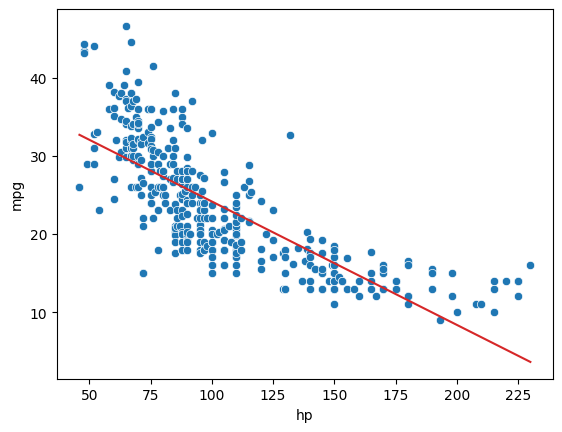

In [7]:
#| fig-alt: "MSE of model with (hp) feature: 23.943662938603104"
pd.options.mode.chained_assignment = None 
vehicles = sns.load_dataset("mpg").dropna().rename(columns = {"horsepower": "hp"}).sort_values("hp")

X = vehicles[["hp"]]
Y = vehicles["mpg"]

hp_model = lm.LinearRegression()
hp_model.fit(X, Y)
hp_model_predictions = hp_model.predict(X)

import matplotlib.pyplot as plt

sns.scatterplot(data=vehicles, x="hp", y="mpg")
plt.plot(vehicles["hp"], hp_model_predictions, c="tab:red");

print(f"MSE of model with (hp) feature: {np.mean((Y-hp_model_predictions)**2)}")

As we can see from the plot, the data follows a curved line rather than a straight one. To capture this non-linearity, we can incorporate **non-linear** features. Let's introduce a **polynomial** term, $\text{hp}^2$, into our regression model. The model now takes the form:

$$\hat{y} = \theta_0 + \theta_1 (\text{hp}) + \theta_2 (\text{hp}^2)$$
$$\hat{y} = \theta_0 + \theta_1 \phi_1 + \theta_2 \phi_2$$

How can we fit a model with non-linear features? We can use the exact same techniques as before: ordinary least squares, gradient descent, or `sklearn`. This is because our new model is still a **linear model**. Although it contains non-linear *features*, it is linear with respect to the model *parameters*. All of our previous work on fitting models was done under the assumption that we were working with linear models. Because our new model is still linear, we can apply our existing methods to determine the optimal parameters. 

MSE of model with (hp^2) feature: 18.98476890761722


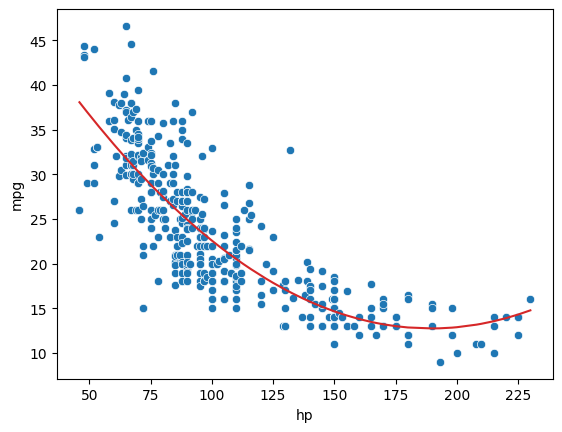

In [8]:
#| fig-alt: "Untransformed data. MSE of model with (hp^2) feature: 18.98476890761722"
# Add a hp^2 feature to the design matrix
X = vehicles[["hp"]]
X["hp^2"] = vehicles["hp"]**2

# Use sklearn to fit the model
hp2_model = lm.LinearRegression()
hp2_model.fit(X, Y)
hp2_model_predictions = hp2_model.predict(X)

sns.scatterplot(data=vehicles, x="hp", y="mpg")
plt.plot(vehicles["hp"], hp2_model_predictions, c="tab:red");

print(f"MSE of model with (hp^2) feature: {np.mean((Y-hp2_model_predictions)**2)}")

Looking a lot better! By incorporating a squared feature, we are able to capture the curvature of the dataset. Our model is now a parabola centered on our data. Notice that our new model's error has decreased relative to the original model with linear features.

### Complexity and Overfitting

We've seen now that feature engineering allows us to build all sorts of features to improve the performance of the model. In particular, we saw that designing a more complex feature (squaring `hp` in the `vehicles` data previously) substantially improved the model's ability to capture non-linear relationships. To take full advantage of this, we might be inclined to design increasingly complex features. Consider the following three models, each of different order (the maximum exponent power of each model):

* Model with order 2: $\hat{y} = \theta_0 + \theta_1 (\text{hp}) + \theta_2 (\text{hp}^2)$
* Model with order 3: $\hat{y} = \theta_0 + \theta_1 (\text{hp}) + \theta_2 (\text{hp}^2) + \theta_3 (\text{hp}^3)$
* Model with order 4: $\hat{y} = \theta_0 + \theta_1 (\text{hp}) + \theta_2 (\text{hp}^2) + \theta_3 (\text{hp}^3) + \theta_4 (\text{hp}^4)$

```{image} images/degree_comparison.png
:alt: Three different plots with differening numbers of polynomial terms.
:width: 900
```

As we can see in the plots above, MSE continues to decrease with each additional polynomial term. To visualize it further, let's plot models as the complexity increases from 0 to 7: 

```{image} images/degree_comparison2.png
:alt: Comparison of plots with different numbers of polynomial terms.
:width: 850
```

When we use our model to make predictions on the same data that was used to fit the model, we find that the MSE decreases with each additional polynomial term (as our model gets more complex). The **training error** is the model's error when generating predictions from the same data that was used for training purposes. We can conclude that the training error goes down as the complexity of the model increases. 

```{image} images/train_error.png
:alt: Conceptual plotting of training error. As model complexity increases, training error decreases.
:width: 400
```

This seems like good news – when working on the **training data**, we can improve model performance by designing increasingly complex models. 

::: {tip} Math Fact: Polynomial Degrees
Given $N$ overlapping data points, we can always find a polynomial of degree $N-1$ that goes through all those points.

For example, there always exists a degree-4 polynomial curve that can perfectly model a dataset of 5 datapoints:

```{image} images/perfect_poly_fits.png
:alt: Three different datasets consisting of five datapoints. Each dataset is perfectly fit by a degree-4 polynomial curve.
:width: 600
```
:::

However, high model complexity comes with its own set of issues. When building the `vehicles` models above, we trained the models on the *entire* dataset and then evaluated their performance on this same dataset. In reality, we are likely to instead train the model on a *sample* from the population, then use it to make predictions on data it didn't encounter during training. 

Let's walk through a more realistic example. Say we are given a training dataset of just 6 datapoints and want to train a model to then make predictions on a *different* set of points. We may be tempted to make a highly complex model (e.g., degree 5), especially given it makes perfect predictions on the training data as clear on the left. However, as shown in the graph on the right, this model would perform *horribly* on the rest of the population! 

```{image} images/complex.png
:alt: On the left is the six datapoints with a perfectly fit curve. On the right, the rest of the population is shown and it is clear that the curve does not fit the population.
:width: 600
```

This phenomenon called **overfitting**. The model effectively just memorized the training data it encountered when it was fitted, leaving it unable to **generalize** well to data it didn't encounter during training. This is a problem: we want models that are generalizable to “unseen” data.

Additionally, since complex models are sensitive to the specific dataset used to train them, they have high **variance**. A model with high variance tends to *vary* more dramatically when trained on different datasets. Going back to our example above, we can see our degree-5 model varies erratically when we fit it to different samples of 6 points from `vehicles`. 

```{image} images/resamples.png
:alt: Three different resamples from the above population.
:width: 800
```

We now face a dilemma: we know that we can **decrease training error** by increasing model complexity, but models that are *too* complex start to overfit and can't be reapplied to new datasets due to **high variance**.

```{image} images/bvt.png
:alt: Illustration of underfitting and overfitting.
:width: 400
```

We can see that there is a clear trade-off that comes from the complexity of our model. As model complexity increases, the model's error on the training data decreases. At the same time, the model's variance tends to increase.

The takeaway here: we need to strike a balance in the complexity of our models; we want models that are generalizable to "unseen" data. A model that is too simple won't be able to capture the key relationships between our variables of interest; a model that is too complex runs the risk of overfitting. 

This begs the question: how do we control the complexity of a model? Stay tuned for Lecture 16 on Cross-Validation and Regularization!

## [Bonus] Time Complexity of the Normal Equation

Let's now dive deeper into gradient and stochastic gradient descent. We discussed earlier how finding the gradient across all the data is extremeley computationally taxing and takes a lot of resources to calculate. Here we'll explore why this is true.

We know that the solution to the normal equation is $\hat{\theta} = (\mathbb{X}^T\mathbb{X})^{-1}\mathbb{X}^T\mathbb{Y}$. Let's break this down and determine the computational complexity for this solution.

```{image} images/complexity_normal_solution.png
:alt: Illustration of the normal equation with matrices.
:width: 600
```

 Let $n$ be the number of samples (rows) and $d$ be the number of features (columns). 

 * Computing $(\mathbb{X}^{\top}\mathbb{X})$ takes $O(nd^2)$ time, and it's inverse takes another $O(d^3)$ time to calculate; overall, $(\mathbb{X}^{\top}\mathbb{X})^{-1}$ takes $O(nd^2) + O(d^3)$ time. 
 * $\mathbb{X}^{\top}\mathbb{Y}$ takes $O(nd)$ time.
 * Multiplying $(\mathbb{X}^{\top}\mathbb{X})^{-1}$ and $\mathbb{X}^{\top}\mathbb{Y}$ takes $O(d^2)$ time. 
 
 In total, calculating the solution to the normal equation takes $O(nd^2) + O(d^3) + O(nd) + O(d^2)$ time. We can see that $O(nd^2) + O(d^3)$ dominates the complexity — this can be problematic for high-dimensional models and very large datasets.

## [Bonus] Stochastic Gradient Descent in `PyTorch`

While this material is out of scope for Data 100, it is useful if you plan to enter a career in data science!

In practice, you will use software packages such as `PyTorch` when computing gradients and implementing gradient descent. You'll often follow three main steps:

1. Sample a batch of the data.
2. Compute the loss and the gradient.
3. Update your gradient until you reach an appropriate estimate of the true gradient.

```{image} images/pytorchsgd.png
:alt: Code for using pytorch to calculate stochastic gradient descent.
:width: 500
```

If you want to learn more, this [Intro to PyTorch tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) is a great resource to get started! 
